# Portugal Forest Fire Analysis

#### Setup

In [ ]:
%pip install pandas matplotlib numpy scikit-learn seaborn

## About the Data.

The forestfires.csv data set was found on kaggle.com [link](https://www.kaggle.com/datasets/ishandutta/forest-fires-data-set-portugal/data)

The data set contains information about 517 different forest fires in northeastern portugal. The columns are as follows
1. X - An X coordinate location of the fire on the Montesohino map
1. Y - A Y coordinate for the location of the fires
1. Month - the 3 letter month that the fire started on.
1. Day - the day of the week that the fire started on.
1. FFMC - The Fine Fuel Moisture Code from the Canadian Forest Fire Weather Index (FWI)
1. DMC - The Duff Moisture Code from the FWI
1. DC - The Drought Code from the FWI
1. ISI - The Initial Spread Index from the FWI
1. Temp - Temperature In Celsius 
1. RH - Relative Humidity as a %
1. Wind - The wind speed in km/h
1. Rain - the amount of rain recorded in mm/m^2
1. Area - the area in hectare of the fire.

#### Import Data

In [1]:
import pandas as pd
import numpy as np
path_to_data = 'forestfires.csv'
fire_data = pd.read_csv(path_to_data)

#### Clean data

In [2]:
#Columnwise data types, null count, and na count

In [3]:
print('Dtypes:', fire_data.dtypes)
print('************************************')
print('Null Count:',fire_data.isnull().sum())
print('************************************')
print('NA Count:', fire_data.isna().sum())

Dtypes: X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object
************************************
Null Count: X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64
************************************
NA Count: X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [4]:
#encode the month and day columns
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop = 'first')
encoded_data = encoder.fit_transform(fire_data[['month', 'day']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['month', 'day']))
fire_data = pd.concat([fire_data.drop(['month', 'day'], axis=1), encoded_df], axis=1)
print(fire_data.columns)

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed'],
      dtype='object')


# Exploration

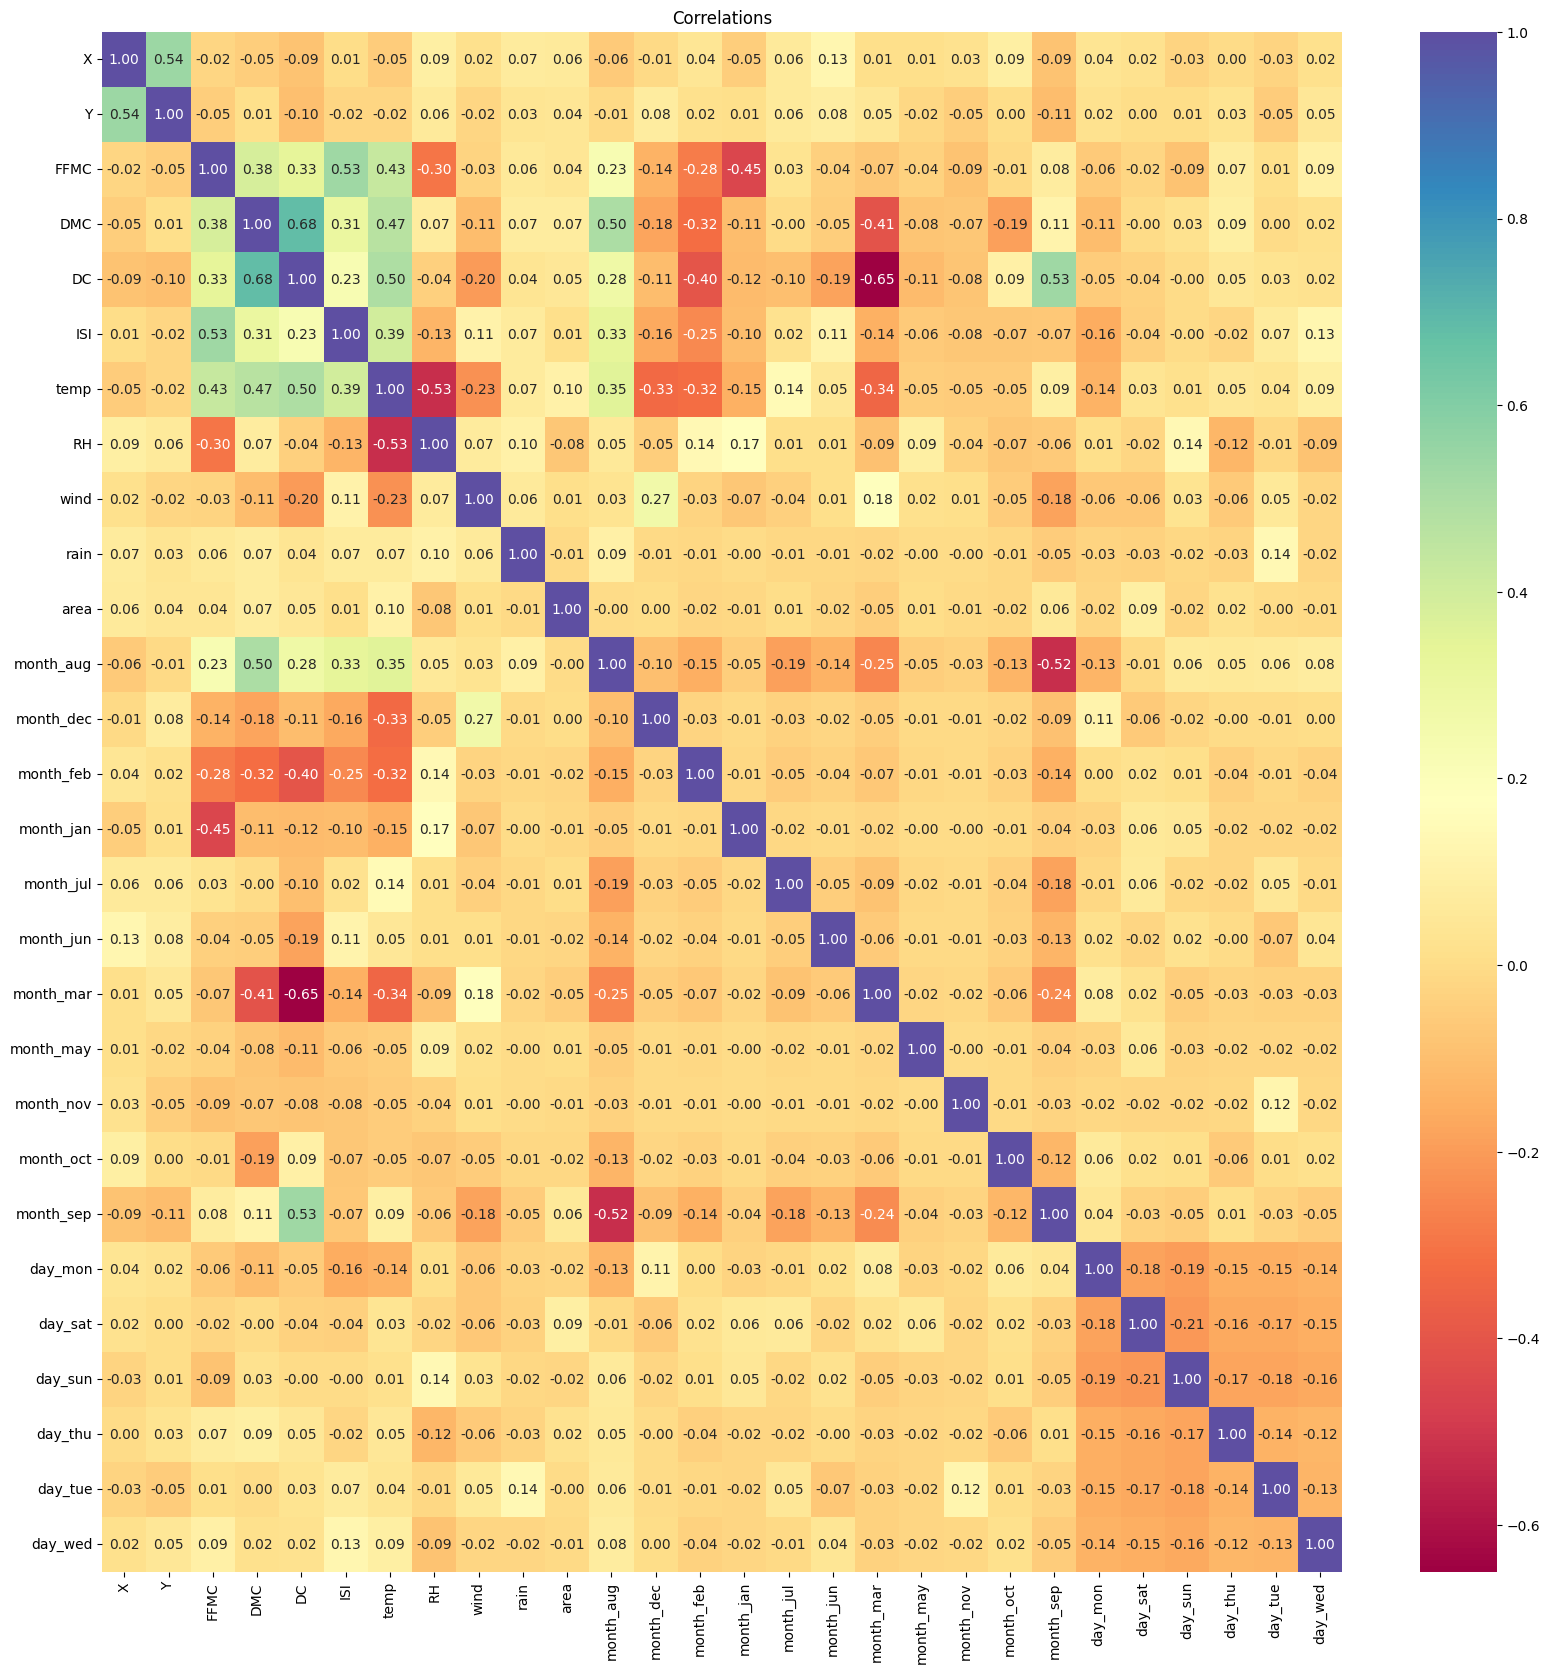

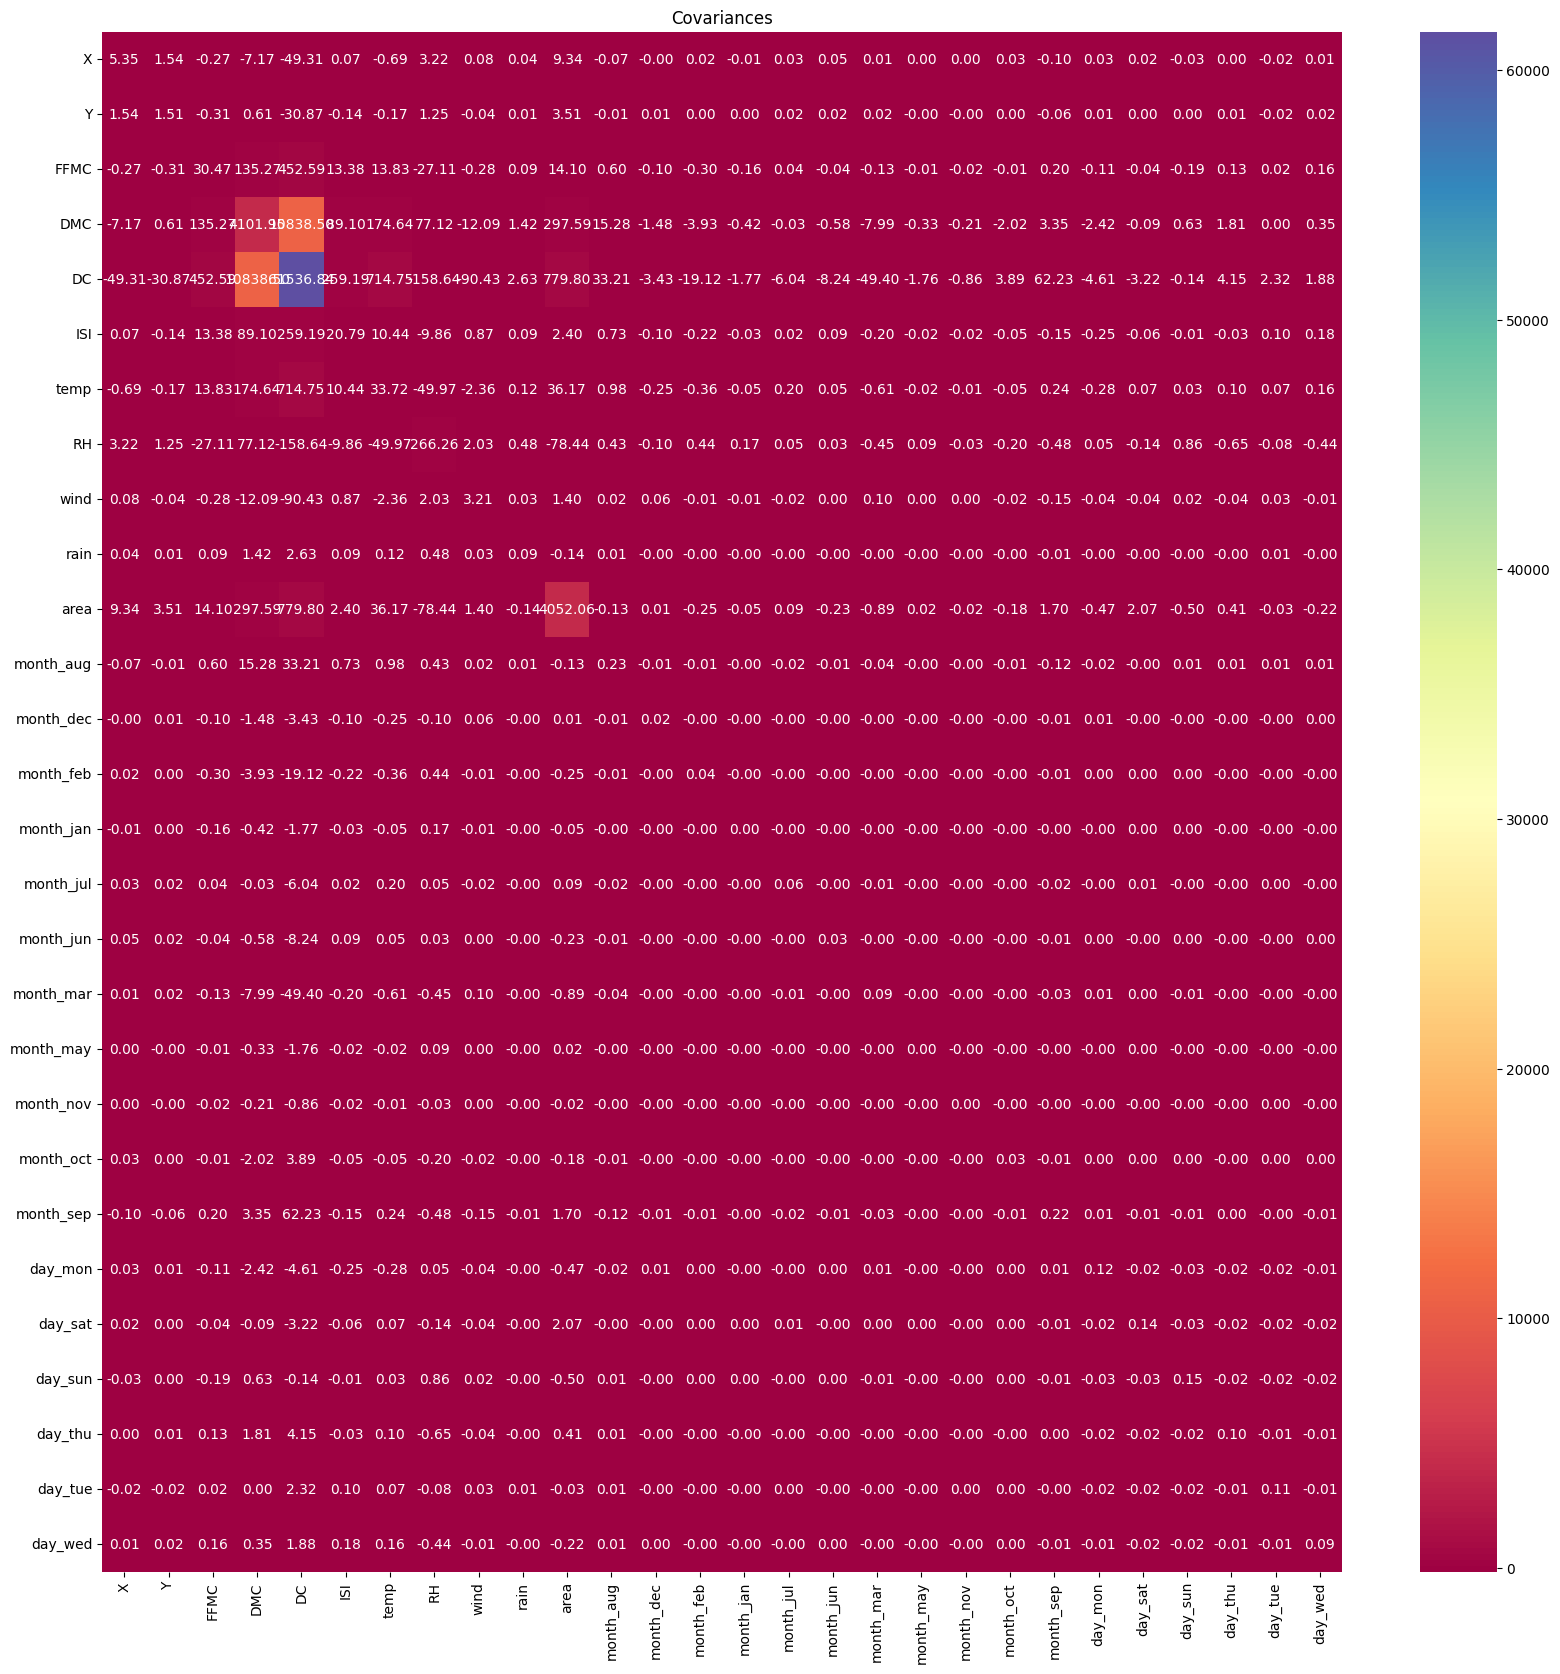

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#Correlation matrix
corr = fire_data.corr()
plt.figure(figsize = (20 , 20))
plt.title('Correlations')
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'Spectral')
plt.show()

#Covariance matrix
plt.figure(figsize = (20 , 20))
plt.title('Covariances')
cov = fire_data.cov()
sns.heatmap(cov, annot = True, fmt = '.2f', cmap = 'Spectral')
plt.show()


# F-Test Regression

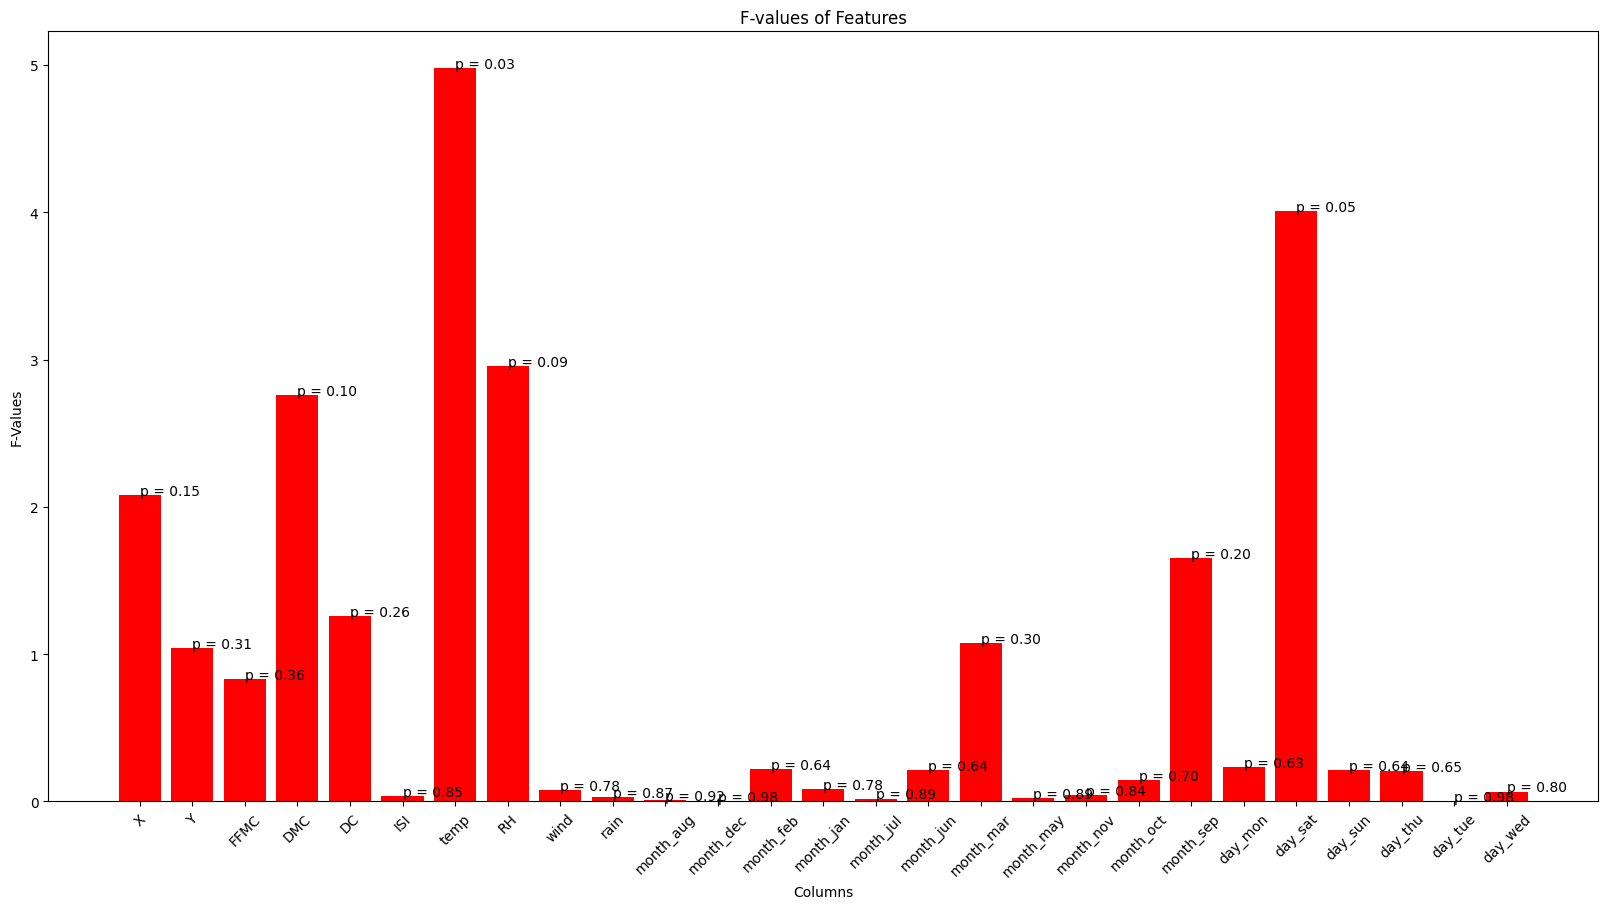

In [12]:
from sklearn.feature_selection import f_regression

#set dependent and independent vars
X = fire_data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed']]
Y = fire_data['area'] 

#perform regression
f_vals, p_vals = f_regression(X, Y)

#bar plot for f_vals and p_vals to show feature importance
plt.figure(figsize = (20, 10))
plt.bar(range(X.shape[1]), f_vals, color = 'red', tick_label = X.columns)
plt.xticks(rotation = 45)
plt.xlabel('Columns')
plt.ylabel('F-Values')
plt.title('F-values of Features')

for i, p_val in enumerate(p_vals):
    plt.text(i, f_vals[i], f'p = {p_val:.2f}')
    
plt.show()



In [24]:
#create l-reg model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5, shuffle = True)

lreg = LinearRegression()

scores = cross_val_score(lreg, X, Y, cv = k_folds, scoring = 'neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print(f"RMSE scores for each fold: {[f'{score:.2f}' for score in rmse_scores]}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE scores for each fold: ['24.96', '35.04', '31.68', '107.95', '78.28']
Average RMSE: 55.58


#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

k_folds = KFold(n_splits = 5, shuffle = True)
randfore = RandomForestRegressor(n_estimators = 100) #100 trees
scores = cross_val_score(randfore, X, Y, cv = k_folds, scoring = 'neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

print(f"RMSE scores for each fold: {[f'{score:.2f}' for score in rmse_scores]}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")


RMSE scores for each fold: ['62.77', '35.87', '80.68', '36.92', '110.09']
Average RMSE: 65.27


In [33]:
#plot tree
from sklearn.tree import plot_tree
randfore.fit(X, Y)
tree = randfore.estimators_[0]



In [36]:
plt.figure(figsize = (20, 20), dpi = 600)
plot_tree(tree, feature_names = X.columns, filled = True, rounded = True, fontsize = 5)
#plt.savefig('tree_high_res.png', format = 'png')
plt.title('Random Forest Tree')
plt.tight_layout()
plt.show()